In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# import required libraries
%matplotlib inline
from scipy.interpolate import CubicSpline 
import matplotlib.pyplot as plt
import seismic.additional_functions as seis
import segyio
import os
import numpy as np

## Practical 2 Bonus: Conducting NMO corrections with a real CMP gather

In this section you will load a segy file of a real CMP gather and conduct your own NMO correction, courtesy of Rob Allen from the VoilA project. You will quickly see that the reality of the situation is more complex then our examples above and there is a need to develop better methods to cope with real seismic data. 

This first section will walk you through how to read in the data, an understanding of how the segyio package works will be developed on Tuesday after lectures 3 and 4. Once the data is read in, use your prior written functions or the prewritten functions to try and obtain an NMO correction section.

In [3]:
file = '../data/VoiLALine1_CDP4000_RA.segy'
f = segyio.open(file, ignore_geometry= False) 

# extract data from file
data = f.trace.raw[:].T
# get key parameters from dataset
dt = (f.samples[1] - f.samples[0]) / 1000 # timestep in s (times are originally in ms)
offsets = abs(f.offsets) #number of receivers / traces
cmp = data # data for each trace
nsamples = cmp.shape[0]
noffsets = cmp.shape[1]
times = np.arange(nsamples)*dt # times

In [9]:
base_segy = segyio.open('../data/VoiLALine1_CDP4000_RA.segy', ignore_geometry= False) 
print (segyio.tools.wrap(base_segy.text[0]))

C 1 CLIENT                        COMPANY                       CREW NO
C 2 LINE            AREA                        MAP ID
C 3 REEL NO           DAY-START OF REEL     YEAR      OBSERVER
C 4 INSTRUMENT: MFG            MODEL            SERIAL NO
C 5 DATA TRACES/RECORD        AUXILIARY TRACES/RECORD         CDP FOLD
C 6 SAMPLE INTERNAL         SAMPLES/TRACE       BITS/IN      BYTES/SAMPLE
C 7 RECORDING FORMAT        FORMAT THIS REEL        MEASUREMENT SYSTEM
C 8 SAMPLE CODE: FLOATING PT     FIXED PT     FIXED PT-GAIN     CORRELATED
C 9 GAIN  TYPE: FIXED     BINARY     FLOATING POINT     OTHER
C10 FILTERS: ALIAS     HZ  NOTCH     HZ  BAND    -     HZ  SLOPE    -    DB/OCT
C11 SOURCE: TYPE            NUMBER/POINT        POINT INTERVAL
C12     PATTERN:                           LENGTH        WIDTH
C13 SWEEP: START     HZ  END     HZ  LENGTH      MS  CHANNEL NO     TYPE
C14 TAPER: START LENGTH       MS  END LENGTH       MS  TYPE
C15 SPREAD: OFFSET        MAX DISTANCE        GROUP INTERVAL

Text(0, 0.5, 'Time (s)')

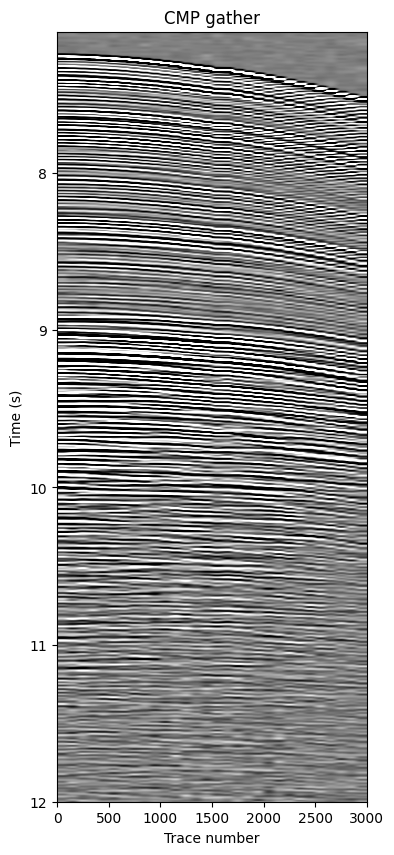

In [27]:
#set cut-off for better visualisation
vm = np.percentile(data, 95)
vmin, vmax = -vm, vm

# set correct axis ranges
extent = [0, data.shape[0], np.max(times), 7.1]
cut = 7100 # starting point in y-axis, no data above this time due to shot/receiver gap
start = int((cut/np.max(f.samples)) * np.shape(data)[0]) #index value for cut

plt.figure(figsize = (4,10))
plt.imshow(data[start:,:], extent= extent, aspect = 'auto', cmap='gray', vmin=vmin, vmax=vmax)
plt.title('CMP gather')
plt.xlabel('Trace number')
plt.ylabel('Time (s)')


There are a lot more reflections here in this CMP gather than in the synthetic we worked with previously!! There will also be noise as this is real data. 

**Excersice: Explore using constant velocities to NMO correct the whole CMP gather that are you know will be too low and too high. What happens to the correction in each case? Are any of the constant velocities suitable for doing the NMO correction?**  For example, you could try velocities of 1000, 1500 and 3000 m/s

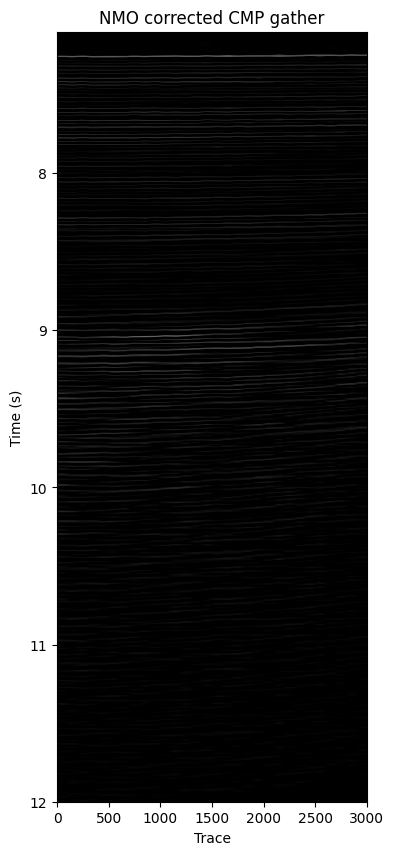

In [70]:
vel = 1500 # vary values (as a minimum try 1000, 1500, 3000)

v_nmo = np.ones(len(times))*vel # constant velocity array for NMO correction
nmo = seis.nmo_correction(cmp, dt, offsets, v_nmo) # NMO correction
    
plt.figure(figsize = (4,10))
plt.imshow(nmo[start:,:], extent= extent, aspect = 'auto', cmap='gray', vmin=vmin, vmax=vmax)
plt.title('NMO corrected CMP gather')
plt.xlabel('Trace')
plt.ylabel('Time (s)')
plt.show()

We will now try and find the correct velocities to use to NMO correct this real CMP gather by doing semblance analysis. We will try a wide range of velocities and plot the amplitude of the stacked trace for each. 

In [34]:
offsets.shape, cmp.shape

((30,), (3001, 30))

20
(20, 3001)
clipping the amplitudes manually from start = 1775... (to avoid direct wave.)


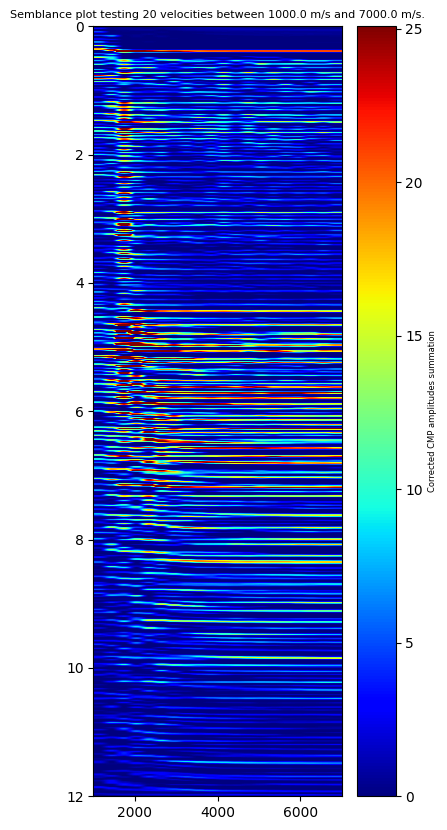

In [61]:
num_velocities_to_test = 20
V_test = np.linspace(1000, 7000, num_velocities_to_test)  # V testing range: [minimum velocity, maximum velocity, number of intervals/steps]

print(len(V_test))

amplitudes = seis.semblance(vs=V_test,
                            cmp=cmp,
                            dt=dt,
                            offsets=offsets,
                            ts=times)

print(amplitudes.shape)

print(f"clipping the amplitudes manually from start = {start}... (to avoid direct wave.)")
amplitudes_to_plot = np.swapaxes(amplitudes, 0, 1)[start:, :].clip(0, np.max(amplitudes)) # starting at T > direct wave and also setting all negative amplitudes to 0

fig, ax = plt.subplots(figsize=(4, 10))
obj = ax.imshow(X=amplitudes_to_plot,
                extent=[np.min(V_test), np.max(V_test), np.max(times), 0],
                aspect="auto",
                cmap='jet',
                vmin=vmin,
                vmax=vmax
                )

ax.set_title(f'Semblance plot testing {len(V_test)} velocities between {np.min(V_test)} m/s and {np.max(V_test)} m/s.', fontsize=8)
fig.colorbar(obj, ax=ax, shrink=1).set_label(label = 'Corrected CMP amplitudes summation', size=6)

In [63]:
num = 10 # number of velocities to be test (semblance plot resolution)
v_test = np.linspace(1000, 4000, num) # V testing range: [minimum velocity, maximum velocity, number of intervals in between]
amp_store = seis.semblance(v_test, cmp, dt, offsets, times) # , verbose = True)
amp_store = np.array(amp_store)

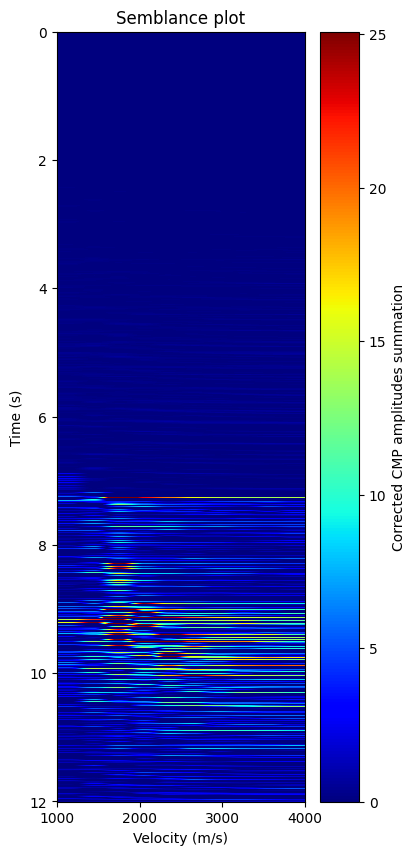

In [80]:
# visualise semblance plot

# clip outlier values for improved visualisation
vm = np.percentile(amp_store.clip(0, np.max(amp_store)), 99) 
vmin, vmax = 0, vm

plt.figure(figsize = (4,10))
plt.imshow(X=np.swapaxes(amp_store,0,1 ), #[start:,:].clip(0, np.max(amp_store)),
           extent=[np.min(v_test), np.max(v_test), dt*nsamples, 0],
           aspect="auto",
           cmap='jet',
           vmin=vmin,
           vmax=vmax
           )

plt.title ('Semblance plot')
plt.colorbar(label = 'Corrected CMP amplitudes summation')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Time (s)')
plt.show()

As a seismic data processor it is your job to pick the correct velocities to use from these semblance plots. This is very subjective, and this process is ripe for digital disruption by data scientists...

[[137, 585]]
[[137, 585], [135, 678]]
[[137, 585], [135, 678], [138, 727]]
[[137, 585], [135, 678], [138, 727], [141, 733]]
[[137, 585], [135, 678], [138, 727], [141, 733], [188, 756]]
[[137, 585], [135, 678], [138, 727], [141, 733], [188, 756], [244, 778]]
NMO_vel=  1666 | time =  7.312
NMO_vel=  1666 | time =  8.476
NMO_vel=  1666 | time =  9.088000000000001
NMO_vel=  1666 | time =  9.164
NMO_vel=  2000 | time =  9.452
NMO_vel=  2333 | time =  9.728


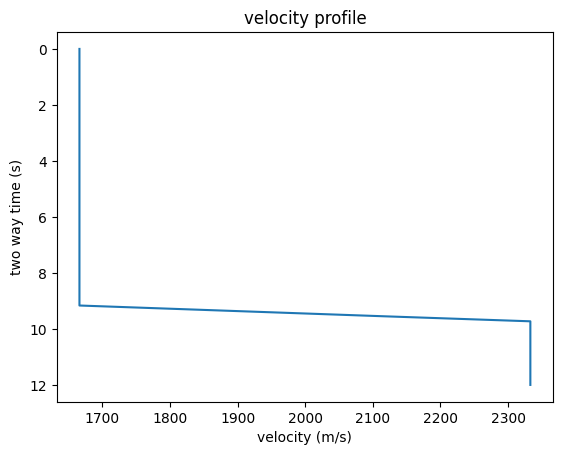

In [102]:
NMO_val = seis.click(amp_store, v_test, times) # right click to obtain data, escape to close window
v_nmo = seis.vel_curve(amp_store, NMO_val, times) # create array containing velocity profile
nmo = seis.nmo_correction(cmp, dt, offsets, v_nmo) # carry out correction, you can use your own NMO function

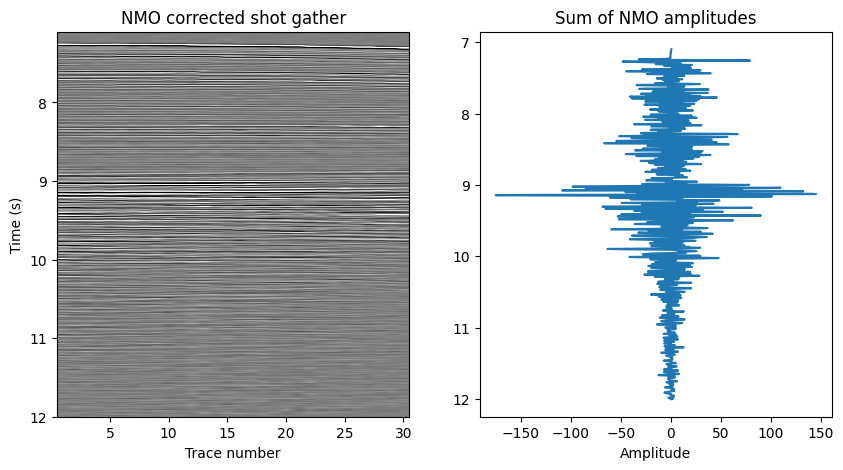

In [103]:
vm = np.percentile(nmo.clip(0, np.max(amp_store)), 99)
vmin, vmax = -vm, vm

fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].imshow(nmo[start:,:], extent=[0.5, noffsets + 0.5, np.max(times), cut/1000], 
          aspect="auto", cmap='gray', vmin=vmin, vmax=vmax)
ax[0].set_title('NMO corrected shot gather')
ax[0].set_xlabel('Trace number')
ax[0].set_ylabel('Time (s)')

ax[1].plot(np.sum(nmo, axis = 1)[start:], times[start:])
ax[1].set_title('Sum of NMO amplitudes')
ax[1].set_xlabel('Amplitude')
ax[1].invert_yaxis()

plt.show()

### END OF SCRIPT